# 7-3，FM模型

FM算法全称为因子分解机 (FactorizationMachine)。

它是广告和推荐领域非常著名的算法，在线性回归模型上考虑了特征的二阶交互。

适合捕捉大规模稀疏特征(类别特征)当中的特征交互。

FM及其衍生的一些较有名的算法的简要介绍如下：

* FM(FactorizationMachine)：在LR基础上用隐向量点积实现自动化特征二阶交叉，且交互项的计算复杂度是O(n)，效果显著好于LR，速度极快接近LR。

* FFM(Field Aware FM): 在FM的基础上考虑对不同的特征域(Field，可以理解成特征的分组)使用不同的隐向量。效果好于FM，但参数量急剧增加，且预测性能急剧下降。

* Bilinear-FFM: 双线性FFM。为了减少FFM的参数量，设计共享矩阵来代替针对不同Field的多个隐向量。效果接近FFM，但参数量大大减少，与FM相当。交互后添加LayerNormlization时效果和略好于FFM.

* DeepFM: 使用FM模型代替DeepWide中的Wide部分，且FM部分的隐向量与Deep部分的Embedding向量是共享的。FM部分可以捕获二阶显式特征交叉，而Deep部分能够捕获高阶隐式特征组合和交叉。

* FiBiNET: 使用SE注意力(Squeeze-and-Excitation)机制来捕获特征重要性，并且使用Bilinear-FFM来捕获二阶特征交互。

参考文章：张俊林《FFM及DeepFFM模型在推荐系统的探索》https://zhuanlan.zhihu.com/p/67795161

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 



In [16]:
import torch 
import torchkeras
print("torch.__version__="+torch.__version__) 
print("torchkeras.__version__="+torchkeras.__version__) 

torch.__version__=2.0.1
torchkeras.__version__=3.9.3


##  一，FM原理解析

FM模型的表达形式如下：

$$y_{FM} = x_0 + \sum_{i=1}^n \omega_i x_i + \sum_{i=1}^{n-1}\sum_{j=i+1}^{n} <\vec{v_i},\vec{v_j}> x_i x_j$$

其中 前两项与 线性回归一致。

第三项为特征交互项。用隐向量的点积来计算交互项的系数。这样做比直接设定一个$n\times n$的交互参数矩阵$W$的好处是减少了参数数量，参数数量从 $n^2$减少为 $n\times k$，其中k为隐向量$v_i$的长度。

从数学上，FM算法用一组向量的两两内积代替了交互参数矩阵$W$，等价于将对称矩阵W分解成如下形式$W=V^TV$，这也是为什么FM算法被叫做因子分解机。

非常有意思的是，交互项的计算复杂度也可以由 $O(n^2)$ 降低为 $O(nk)$，这样FM前向推断的计算复杂度近似为线性复杂度。对于特征数量n非常大而稀疏的模型，计算起来毫无压力。


交互项的简化计算类似于 $ab+ac+bc =\frac{1}{2} ((a+b+c)^2-(a^2+b^2+c^2))$

$$\sum_{i=1}^{n-1}\sum_{j=i+1}^{n} <\vec{v_i},\vec{v_j}> x_i x_j
= \frac{1}{2}(\sum_{i=1}^{n}\sum_{j=1}^{n} <\vec{v_i},\vec{v_j}> x_i x_j - \sum_{i=1}^{n} <\vec{v_i},\vec{v_i}> x_i x_i)$$
$$= \frac{1}{2}(\sum_{i=1}^{n}\sum_{j=1}^{n} \sum_{f=1}^{k} v_{if}v_{jf} x_i x_j - \sum_{i=1}^{n} \sum_{f=1}^{k} v_{if}v_{if} x_i x_i)$$

$$= \frac{1}{2}\sum_{f=1}^{k}(\sum_{i=1}^{n}\sum_{j=1}^{n}  v_{if}v_{jf} x_i x_j - \sum_{i=1}^{n}  v_{if}v_{if} x_i x_i)$$

$$= \frac{1}{2}\sum_{f=1}^{k}((\sum_{i=1}^{n}v_{if}x_i)^2  - \sum_{i=1}^{n}  (v_{if} x_i)^2)$$

可以看到交互项的计算复杂度已经变成 $O(nk)$ 了

因此 FM的模型形式也可以改写成：

$$y_{FM} = x_0 + \sum_{i=1}^n \omega_i x_i +\frac{1}{2}\sum_{f=1}^{k}((\sum_{i=1}^{n}v_{if}x_i)^2  - \sum_{i=1}^{n}  (v_{if} x_i)^2)$$

注意到 

$$\frac{\partial{y_{FM}}}{\partial{v_{if}}} = (\sum_{j=1}^{n}v_{jf}x_j) x_i - v_{if}x_i^2$$
$$= x_i((\sum_{j=1}^{n}v_{jf}x_j)  - v_{if}x_i)$$

可见，只要训练样本中存在不等于0的 $x_i$ ，就能够给隐向量$\vec{v_{i}}$贡献梯度，从而学到有效的$\vec{v_{i}}$表示。

同理，只要训练样本中存在不等于0的 $x_j$ ，就能够给隐向量$\vec{v_{j}}$贡献梯度，从而学到有效的$\vec{v_{j}}$表示。

然后，就可以计算出有意义的交互项的权重$<\vec{v_{i}},\vec{v_{j}}>$。

这非常重要，这说明非零的交互项权重可以在训练样本中不存在 $x_i$和$x_j$同时不为0的样本的发生。

这是FM面对稀疏特征具有很强泛化性的原因。

考虑一个典型的给用户推荐商品的推荐场景中，用户所在城市特征和商品类目特征的交互。

葫芦岛是一个小城市，渔网是一种小众商品。它们都是稀疏特征，绝大部分样本在这两个onehot位上的取值都是0.

稀疏乘以稀疏更加稀疏，所以在训练样本中可能根本不存在葫芦岛城市的用户购买渔网这样的样本。

但是只要训练样本中存在着葫芦岛的用户购买其它商品这样的样本，也存在其他城市用户购买渔网这样的样本，FM模型就可以给葫芦岛市的用户购买渔网的可能性作出一个估计，这个值可能不小，最后甚至会给葫芦岛的用户推荐渔网。

这就是FM面对稀疏特征具有很强泛化性的一个例子。








## 二，Pytorch代码实现

下面是FM模型的一个完整pytorch实现。

$$\sum_{i=1}^{n-1}\sum_{j=i+1}^{n} <\vec{v_i},\vec{v_j}> x_i x_j = \sum_{i=1}^{n-1}\sum_{j=i+1}^{n} <x_i\vec{v_i},x_j\vec{v_j}> $$

注意的是，我们代码中的embedding向量或者线性层作用结果实际上是 $x_i\vec{v_i}$ 的结果。这是许多读者包括我在学习FM时候感到困惑的一个地方。

对于 离散特征，onehot编码后其 $x_i $ 总是等于1或者0，$x_i$不为0的那些项才会保留到结果中，此时$x_i$总是等于1，因此$x_i\vec{v_i}$就等于其embedding向量。对于连续特征，通过一个不带偏置的Linear层作用，获取到的实际上就是 $x_i\vec{v_i}$，包含了$x_i$因子。


In [2]:
import torch 
from torch import nn
from torch import nn,Tensor 
import torch.nn.functional as F 

class NumEmbedding(nn.Module):
    """
    连续特征用linear层编码
    输入shape: [batch_size,features_num(n), d_in], # d_in 通常是1
    输出shape: [batch_size,features_num(n), d_out]
    """
    
    def __init__(self, n: int, d_in: int, d_out: int, bias: bool = False) -> None:
        super().__init__()
        self.weight = nn.Parameter(Tensor(n, d_in, d_out))
        self.bias = nn.Parameter(Tensor(n, d_out)) if bias else None
        with torch.no_grad():
            for i in range(n):
                layer = nn.Linear(d_in, d_out)
                self.weight[i] = layer.weight.T
                if self.bias is not None:
                    self.bias[i] = layer.bias

    def forward(self, x_num):
        # x_num: batch_size, features_num, d_in
        assert x_num.ndim == 3
        #x = x_num[..., None] * self.weight[None]
        #x = x.sum(-2)
        x = torch.einsum("bfi,fij->bfj",x_num,self.weight)
        if self.bias is not None:
            x = x + self.bias[None]
        return x
    
class CatEmbedding(nn.Module):
    """
    离散特征用Embedding层编码
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,features_num, d_embed]
    """
    def __init__(self, categories, d_embed):
        super().__init__()
        self.embedding = nn.Embedding(sum(categories), d_embed)
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)
        
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x_cat):
        """
        :param x_cat: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return self.embedding(x) 
    
class CatLinear(nn.Module):
    """
    离散特征用Embedding实现线性层（等价于先F.onehot再nn.Linear()）
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,d_out]
    """
    def __init__(self, categories, d_out=1):
        super().__init__()
        self.fc = nn.Embedding(sum(categories), d_out)
        self.bias = nn.Parameter(torch.zeros((d_out,)))
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)

    def forward(self, x_cat):
        """
        :param x: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return torch.sum(self.fc(x), dim=1) + self.bias 
    
    
class FMLayer(nn.Module):
    """
    FM交互项
    """

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x): #注意：这里的x是公式中的 <v_i> * xi
        """
        :param x: Float tensor of size ``(batch_size, num_features, k)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix
    
class FM(nn.Module):
    """
    完整FM模型。
    """

    def __init__(self, d_numerical, categories=None, d_embed=4,
                 n_classes = 1):
        super().__init__()
        if d_numerical is None:
            d_numerical = 0
        if categories is None:
            categories = []
        self.categories = categories
        self.n_classes = n_classes
        
        self.num_linear = nn.Linear(d_numerical,n_classes) if d_numerical else None
        self.cat_linear = CatLinear(categories,n_classes) if categories else None
        
        self.num_embedding = NumEmbedding(d_numerical,1,d_embed) if d_numerical else None
        self.cat_embedding = CatEmbedding(categories, d_embed) if categories else None
        
        if n_classes==1:
            self.fm = FMLayer(reduce_sum=True)
            self.fm_linear = None
        else:
            assert n_classes>=2
            self.fm = FMLayer(reduce_sum=False)
            self.fm_linear = nn.Linear(d_embed,n_classes)

    def forward(self, x):
        
        """
        x_num: numerical features
        x_cat: category features
        """
        x_num,x_cat = x
        
        #linear部分
        x = 0.0
        if self.num_linear:
            x = x + self.num_linear(x_num) 
        if self.cat_linear:
            x = x + self.cat_linear(x_cat)
        
        #交叉项部分
        x_embedding = []
        if self.num_embedding:
            x_embedding.append(self.num_embedding(x_num[...,None]))
        if self.cat_embedding:
            x_embedding.append(self.cat_embedding(x_cat))
        x_embedding = torch.cat(x_embedding,dim=1)
        
        if self.n_classes==1:
            x = x + self.fm(x_embedding)
            x = x.squeeze(-1)
        else: 
            x = x + self.fm_linear(self.fm(x_embedding)) 
        return x
    
    

In [3]:
##测试 NumEmbedding

num_embedding = NumEmbedding(2,1,4)
x_num = torch.randn(2,2)
x_out = (num_embedding(x_num.unsqueeze(-1)))
print(x_out.shape)        


torch.Size([2, 2, 4])


In [4]:
##测试 CatEmbedding

cat_embedding = CatEmbedding(categories = [3,2,2],d_embed=4) 
x_cat = torch.randint(0,2,(2,3))
x_out = cat_embedding(x_cat)
print(x_cat.shape)
print(x_out.shape)


torch.Size([2, 3])
torch.Size([2, 3, 4])


In [5]:
##测试 CatLinear

cat_linear = CatLinear(categories = [3,2,2],d_out=1) 
x_cat = torch.randint(0,2,(2,3))
x_out = cat_linear(x_cat)
print(x_cat.shape)
print(x_out.shape)


torch.Size([2, 3])
torch.Size([2, 1])


In [6]:
##测试 FMLayer

fm_layer = FMLayer(reduce_sum=False)

x = torch.randn(2,3,4)
x_out = fm_layer(x)
print(x_out.shape)


torch.Size([2, 4])


In [7]:
##测试 FM

fm = FM(d_numerical = 3, categories = [4,3,2],
        d_embed = 4,n_classes = 2)
self = fm 
x_num = torch.randn(2,3)
x_cat = torch.randint(0,2,(2,3))
fm((x_num,x_cat))


tensor([[ 0.4033,  1.3612],
        [ 2.8410, -4.4903]], grad_fn=<AddBackward0>)

## 三，Cretio数据集完整范例

Cretio数据集是一个经典的广告点击率CTR预测数据集。

这个数据集的目标是通过用户特征和广告特征来预测某条广告是否会为用户点击。

数据集有13维数值特征(I1至I13)和26维类别特征(C14至C39), 共39维特征, 特征中包含着许多缺失值。

训练集4000万个样本，测试集600万个样本。数据集大小超过100G.

此处使用的是采样100万个样本后的cretio_small数据集。


In [ ]:
#!pip install torchkeras

In [8]:
import numpy as np 
import pandas as pd 
import datetime 

from sklearn.model_selection import train_test_split 

import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader  
import torch.nn.functional as F 
import torchkeras 



### 1，准备数据

In [9]:
from sklearn.preprocessing import LabelEncoder,QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 

dfdata = pd.read_csv("./eat_pytorch_datasets/criteo_small.zip",sep="\t",header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

for col in cat_cols:
    dfdata[col]  = LabelEncoder().fit_transform(dfdata[col])

dfdata[num_cols] = num_pipe.fit_transform(dfdata[num_cols])

categories = [dfdata[col].max()+1 for col in cat_cols]



In [10]:
import torch 
from torch.utils.data import Dataset,DataLoader 

#DataFrame转换成torch数据集Dataset, 特征分割成X_num,X_cat方式
class DfDataset(Dataset):
    def __init__(self,df,
                 label_col,
                 num_features,
                 cat_features,
                 categories,
                 is_training=True):
        
        self.X_num = torch.tensor(df[num_features].values).float() if num_features else None
        self.X_cat = torch.tensor(df[cat_features].values).long() if cat_features else None
        self.Y = torch.tensor(df[label_col].values).float() 
        self.categories = categories
        self.is_training = is_training
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if self.is_training:
            return ((self.X_num[index],self.X_cat[index]),self.Y[index])
        else:
            return (self.X_num[index],self.X_cat[index])
    
    def get_categories(self):
        return self.categories


In [11]:
dftrain_val,dftest = train_test_split(dfdata,test_size=0.2)
dftrain,dfval = train_test_split(dftrain_val,test_size=0.2)

ds_train = DfDataset(dftrain,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_val = DfDataset(dfval,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_test = DfDataset(dftest,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)



In [12]:
dl_train = DataLoader(ds_train,batch_size = 2048,shuffle=True)
dl_val = DataLoader(ds_val,batch_size = 2048,shuffle=False)
dl_test = DataLoader(ds_test,batch_size = 2048,shuffle=False)

for features,labels in dl_train:
    break 
    

### 2，定义模型

In [13]:
def create_net():
    net = FM(
        d_numerical= ds_train.X_num.shape[1],
        categories= ds_train.get_categories(),
        d_embed = 8, 
        n_classes = 1
    )
    return net 

from torchkeras import summary

net = create_net()
summary(net,input_data=features);



--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 1]                   14
Embedding-2                              [-1, 26, 1]            1,296,709
NumEmbedding-3                           [-1, 13, 8]                  104
Embedding-4                              [-1, 26, 8]           10,373,672
FMLayer-5                                    [-1, 1]                    0
Total params: 11,670,499
Trainable params: 11,670,499
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000084
Forward/backward pass size (MB): 0.002594
Params size (MB): 44.519421
Estimated Total Size (MB): 44.522099
--------------------------------------------------------------------------


### 3，训练模型

我们使用梦中情炉torchkeras来实现最优雅的训练循环。

In [14]:
from torchkeras import KerasModel
from torchkeras.metrics import AUC

net = create_net()
loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}
optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=0.001) 

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )         


<<<<<< 🐌 cpu is used >>>>>>


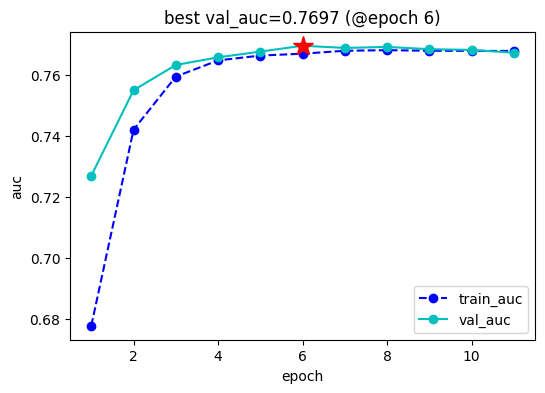

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



In [15]:
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=5,
    monitor='val_auc',
    mode='max',
    plot=True,
    cpu=True
)


### 4，评估模型

In [23]:
model.evaluate(dl_test)

100%|████████████████████████████████| 98/98 [00:04<00:00, 24.16it/s, val_auc=0.769, val_loss=0.475]


{'val_loss': 0.47518228997989576, 'val_auc': 0.7691175937652588}

### 5，使用模型

In [22]:
from sklearn.metrics import roc_auc_score
model.eval()
dl_test = model.accelerator.prepare(dl_test)
with torch.no_grad():
    result = torch.cat([model.forward(t[0]) for t in dl_test])

preds = F.sigmoid(result)
labels = torch.cat([x[-1] for x in dl_test])

val_auc = roc_auc_score(labels.numpy(),preds.numpy())
print(val_auc)


0.7691173430695828


### 6，保存模型

模型最佳权重已经保存在 model.fit(ckpt_path) 传入的参数中了。

In [21]:
net_clone = create_net()
net_clone.load_state_dict(torch.load(model.ckpt_path))


<All keys matched successfully>

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)